# ASL Classifier Basic - Training
This notebook trains a basic classifier for the task of American Sign Language detection for the DSPRO2 project at HSLU.

## Setup
In this section ensures all the necessary libraries are imported.

In [ ]:
%pip install -r requirements.txt -q

And the necessary imports are executed.

In [3]:
import torch
import torch.nn as nn
import torchvision.models 
import torchvision.transforms as transforms

from datapipeline.asl_landmarks_data_module import ASLLandmarksDataModule
from lightning.pytorch.loggers import WandbLogger
from models.asl_model import ASLModel
from models.training import train, PROJECT_NAME, ENTITY_NAME

In [4]:
import wandb
import torch
import torch.nn as nn
import torchvision.models as visionmodels
import torchvision.transforms.v2 as transforms
import lightning as L

from lightning.pytorch.loggers import WandbLogger

import nbformat

from typing import Callable

import os

# Our own modules
import models.sweep_helper as sweep_helper

from datapipeline.asl_landmarks_data_module import ASLLandmarksDataModule
from models.asl_model import ASLModel
from models.training import sweep, train_model

In [5]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./dspro2/asl_classifier_basic.ipynb"

## Preprocessing
No general data preprocessing is necessary, however the landmarks have been extracted form the original data in a preprocessing step and are now being loaded.

In [6]:
PATH = "/exchange/dspro2/silent-speech/ASL_Landmarks_Dataset"

In [7]:
datamodule = ASLLandmarksDataModule(path=PATH)

## Model
This section defines the model architecture, based on the ResNet model.

In [8]:
class ASLClassifierBasic(nn.Module):
    def __init__(self, input_size=63, num_classes=28):
        super(ASLClassifierBasic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

## Training
This section contains the training of the model. First by defining several methods that will be used in the effective training procedure later on. This section is setup to be run multiple times for different experiments.

In [9]:
sweep_config = {
    "method": "grid",
    "parameters": {
        "lr": {"values": [0.001, 0.01]},
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate_scheduler": {
            "values": [
                {"type": "step", "step_size": 10, "gamma": 0.1},
                {"type": "none"}
            ]
        }
    }
}


In [10]:
def get_model(config):
    model = ASLClassifierBasic(input_size=63, num_classes=28)
    test_input = torch.randn(4, 63)
    with torch.no_grad():
        out = model(test_input)
    print("Model output shape:", out.shape)
    return model


In [11]:
def get_optimizer(config, model):
    lr = config.get("lr", 1e-3)
    optimizer_type = config.get("optimizer", "adam").lower()
    if optimizer_type == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")


In [14]:
def training_procedure():
    run = wandb.init()  # Correctly start run
    wandb.run.name = f"asl_classifier_basic-{run.id}"  # Set name

    config = wandb.config

    model = ASLClassifierBasic(input_size=63, num_classes=28)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    datamodule = ASLLandmarksDataModule(path="/exchange/dspro2/silent-speech/ASL_Landmarks_Dataset")

    asl_model = ASLModel(model=model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer)

    train(model=asl_model, datamodule=datamodule, logger=WandbLogger(log_model=True))

    wandb.finish()


In [ ]:

sweep(sweep_config, count=10, training_procedure=training_procedure)

## Evaluation
This section contains the evaluation of the selected model. It will load the model from a checkpoint, previously downloaded from a Weights & Biases run and evaluate it on the test set.


🧪 Test label distribution:
A: 19
B: 22
C: 14
D: 15
E: 24
F: 22
G: 22
H: 18
I: 21
J: 21
K: 27
L: 26
M: 20
N: 18
Nothing: 1
O: 16
P: 15
Q: 16
R: 22
S: 25
Space: 15
T: 22
U: 23
V: 22
W: 16
X: 22
Y: 26
Z: 21

🧪 Unique labels in test set: [np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E'), np.str_('F'), np.str_('G'), np.str_('H'), np.str_('I'), np.str_('J'), np.str_('K'), np.str_('L'), np.str_('M'), np.str_('N'), np.str_('Nothing'), np.str_('O'), np.str_('P'), np.str_('Q'), np.str_('R'), np.str_('S'), np.str_('Space'), np.str_('T'), np.str_('U'), np.str_('V'), np.str_('W'), np.str_('X'), np.str_('Y'), np.str_('Z')]
✅ Expected class order: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Nothing']
✅ Evaluation complete.

              precision    recall  f1-score   support

           A       0.59      0.68      0.63        19
           B       1.00      0.91      0.95        22


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


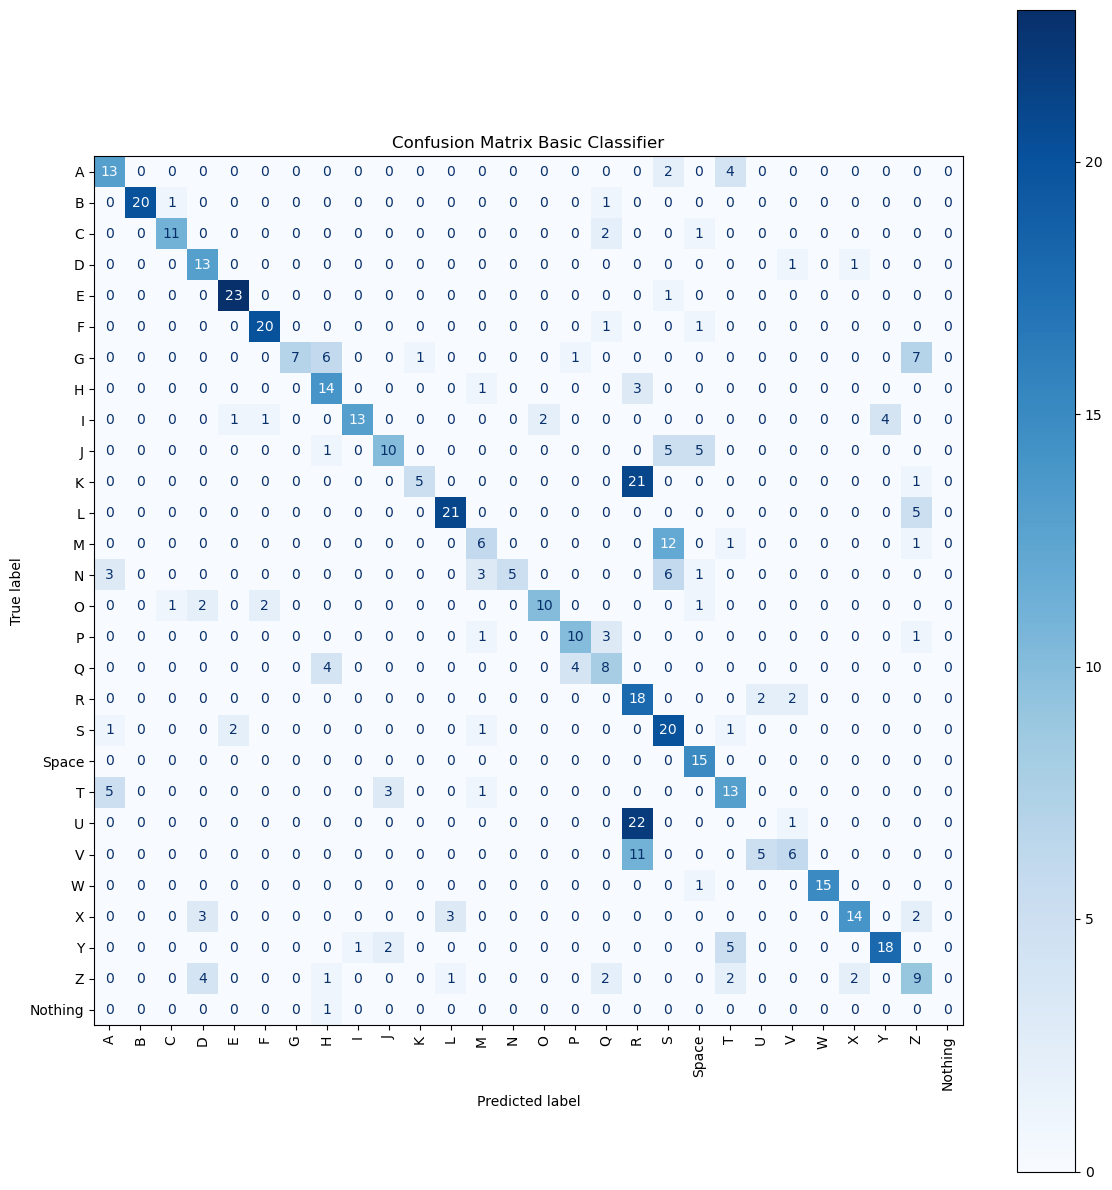

In [1]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----- Load Lightning Checkpoint -----
ckpt_path = "asl_classifier_basic.ckpt"
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
state_dict = {k.replace("model.", ""): v for k, v in checkpoint['state_dict'].items()}

# ----- Define the Model Architecture -----
model = nn.Sequential(
    nn.Linear(63, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 28)
)
model.load_state_dict(state_dict)
model.eval()

# ----- Load and Prepare Test Data -----
data_dir = Path('/exchange/dspro2/silent-speech/Test_Images_Landmarks')
X_list, y_list = [], []

# Force loading order using class_order
class_order = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
    'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Nothing'
]
for label in class_order:
    x_file = data_dir / f"X_{label}.npy"
    y_file = data_dir / f"y_{label}.npy"
    if x_file.exists() and y_file.exists():
        X = np.load(x_file)
        y = np.load(y_file)

        
        X_list.append(X)
        y_list.append(y)

X_test = np.vstack(X_list)
y_test = np.concatenate(y_list)

# ----- Inspect Test Label Distribution -----
unique, counts = np.unique(y_test, return_counts=True)
print("\n🧪 Test label distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {count}")

# ----- Check for Label Alignment with Class Order -----
# class_order already defined above; no need to redefine it
print("\n🧪 Unique labels in test set:", sorted(set(y_test)))
print("✅ Expected class order:", class_order)

# ----- Manual Label Encoding to Match Training -----
le = LabelEncoder()
le.fit(class_order)
y_test_encoded = np.array([class_order.index(label) for label in y_test])

# ----- Predict -----
X_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    logits = model(X_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

# ----- Classification Report -----
print("\u2705 Evaluation complete.\n")
print(classification_report(y_test_encoded, y_pred, target_names=class_order))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test_encoded, y_pred)

# Reorder matrix to match A-Z, Space, Nothing
index_order = list(range(len(class_order)))  # class_order is already the correct order
cm_sorted = cm[np.ix_(index_order, index_order)]

# Plot reordered matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=class_order)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix Basic Classifier")
plt.tight_layout()
plt.savefig("confusion_matrix_basic.png", dpi=300)
plt.show()
